In [1]:
import sys

# Specify the directory you want to add
custom_path = './..'

# Add the directory to sys.path
if custom_path not in sys.path:
    sys.path.append(custom_path)

In [2]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!ls

DELETE_THIS_empty.ipynb				 sweek_repara_1.log
ZZZZ_nl_experiments_tanh.ipynb			 sweek_repara_1.pkl
ZZZ_bkp_oldReLU.ipynb				 sweek_repara_10.cfg
ZZZ_delete_nl_experiments-Copy4.ipynb		 sweek_repara_10.log
__init__.py					 sweek_repara_10.pkl
antifrog_demo.ipynb				 sweek_repara_11.cfg
avraham_data_bringup.ipynb			 sweek_repara_11.log
basline_example_forDK.ipynb			 sweek_repara_11.pkl
collect_fitting_clean_nans.ipynb		 sweek_repara_12.cfg
collect_fitting_info101-3a-BUGBUG.ipynb		 sweek_repara_12.log
collect_fitting_info101-3a-val.ipynb		 sweek_repara_12.pkl
collect_fitting_info101-3a.ipynb		 sweek_repara_13.cfg
collect_fitting_info101-repa.ipynb		 sweek_repara_13.log
collect_fitting_info101.ipynb			 sweek_repara_13.pkl
debug_full_repertoire.ipynb			 sweek_repara_14.cfg
fit_single_v1.py				 sweek_repara_14.log
focus_on_comboNerr_sweeps.ipynb			 sweek_repara_14.pkl
focus_on_combo_sweeps.ipynb			 sweek_repara_15.cfg
focus_on_error_learning.ipynb			 sweek_repara_15.log
focus_on_error_learn

In [4]:
opt_data = {}
for i in range(24):
    with open(f'sweek_repara_{i}.pkl','rb') as f:
        opt_data[i] = pickle.load(f)

In [5]:
opt_data

{0: {'MSE':                         fun: 128.95802545285642
   lowest_optimization_result:       fun: 128.95802545285642
   hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 8.40779819e+02,  0.00000000e+00,  6.77370736e+02, -2.94835421e-01])
    message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 595
        nit: 16
       njev: 119
     status: 0
    success: True
          x: array([-4.53743937, -0.9       ,  0.17685655, 39.71926225])
                      message: ['requested number of basinhopping iterations completed successfully']
        minimization_failures: 18
                         nfev: 10630
                          nit: 100
                         njev: 2126
                            x: array([-4.53743937, -0.9       ,  0.17685655, 39.71926225])},
 1: {'MSE':                         fun: 120.3603933661198
   lowest_optimization_result:       fun: 120.3603933661198
   hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [7]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}
fixed_params['model'] =  dict(n_inputs = 3,
        n_hidden = 5*4*512,
        n_outs = 1,
        en_bias = False,
        b_high=3, first_layer_init='ones',
        first_layer_weights_trainable = True,
        out_layer_init='zeros')         

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,1,0], 'sigma_noi':0.0, 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None}

optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('custom','w'),
                    ('postprocessing','scale'),
                    ]

custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['normalized_log_lr']/x['w']},
                            {'cathegory':'model','param_name':'nl','fun': lambda x: (lambda : OneOverSqr(w=x['w']))}]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [8]:
df = pd.read_csv('../../../frogs_project/data/avraham__ivry_fig1_rotFig1_v2.csv',header=None)
df = df.T
data = df.to_numpy()

In [9]:
stimulus = [(1,40),(0,40)]
pooling_fun = 'MSE'

In [10]:
errors = [opt_data[k][pooling_fun]['fun'] for k in opt_data]


In [11]:
np.mean(errors)

nan

In [12]:
outs  = {k: wrapped_runner([(1,40),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data}

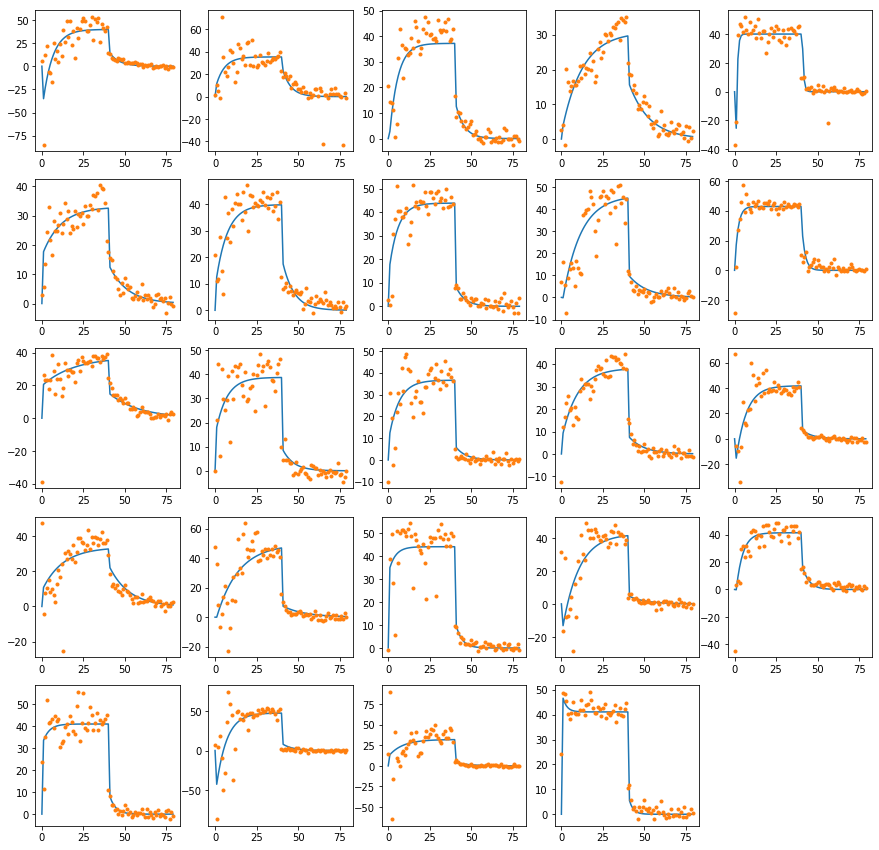

In [13]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k])
    plt.plot(data[:80,k],'.')
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [ ]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k])
    plt.plot(smooth_signal(data[:80,k],3),'.')

In [15]:
outs_ = [o for _,o in outs.items()]
outs_ = np.array(outs_)

In [17]:
diffs = outs_.T-data[:80,:]
np.mean(diffs**2)

77.09681672396538

In [ ]:
for setting in pooling_funs +[appendix]:
    plt.plot(outs[setting])
plt.plot(data[:,0],'x')
plt.plot(data[:80,0],'x')

plt.xlim([39,120])
plt.ylim([-5,60])


In [ ]:
mae = lambda x: np.mean(np.abs(x))
mse = lambda x: np.mean(np.square(x))


In [ ]:
for setting in pooling_funs +[appendix]:
    fit_err = outs[setting][:80] - data[:80,0]
    val_err = outs[setting][80:] - data[80:,0]
    print(f'fit objective: {setting}')
    print(f' fitting MAE: {mae(fit_err)}; MSE: {mse(fit_err)}')
    print(f' validation MAE: {mae(val_err)}; MSE: {mse(val_err)}')

In [ ]:
import scipy
scipy.__version__

In [ ]:
# !pip3 install --upgrade pip

In [ ]:
# pip install --upgrade scipy

In [ ]:
import pickle

In [ ]:
with open('sweep_1_subj_12.pkl','rb') as f:
    opt_data = pickle.load(f)

In [ ]:
opt_data